Привет! меня зовут Люман Аблаев. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>


<font color='orange' style='font-size:24px; font-weight:bold'>Общее впечатление</font>
* Спасибо за то, что прислал  качественную работу, видно, что приложено много усилий.
- Код написать читабельно - приятно проверять такие работы
- Я оставил некоторые советы, надеюсь они будут полезными или интересными.
- В работе есть пару недочетов и не хватает итогового вывода, дополни пожалуйста проект
* Жду твою обновленную работу


<font color='orange' style='font-size:24px; font-weight:bold'>Общее впечатление[2]</font>
* Спасибо за то оперативные правки.
- Ты исправил многие недочеты и работа стала еще лучше.
- Осталось добиться желаемой метрики на тесте и написать вывол и работа будет зачтена.
- Давай еще разок

<font color='orange' style='font-size:24px; font-weight:bold'>Общее впечатление[3]</font>
* Твои усердные доработки корректны, и теперь проект является завершенным, поздравляю!
- Не смею больше задерживать, удачи в дальнейшем обучении!

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span><ul class="toc-item"><li><span><a href="#Признак-Age-категоральный-преобразуем-значение-техникой-OHE" data-toc-modified-id="Признак-Age-категоральный-преобразуем-значение-техникой-OHE-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Признак Age категоральный преобразуем значение техникой OHE</a></span></li><li><span><a href="#Признак-Geography-преобразуем-техникой-OrdinalEncoding" data-toc-modified-id="Признак-Geography-преобразуем-техникой-OrdinalEncoding-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Признак Geography преобразуем техникой OrdinalEncoding</a></span></li><li><span><a href="#Масштабируем-признаки-(перенес-в-другой-раздел)" data-toc-modified-id="Масштабируем-признаки-(перенес-в-другой-раздел)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Масштабируем признаки (перенес в другой раздел)</a></span></li><li><span><a href="#Разобъем-данные-на-обучающую-и-валидационну-и-тестовую-выборки" data-toc-modified-id="Разобъем-данные-на-обучающую-и-валидационну-и-тестовую-выборки-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Разобъем данные на обучающую и валидационну и тестовую выборки</a></span></li><li><span><a href="#Масштабируем-признаки" data-toc-modified-id="Масштабируем-признаки-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Масштабируем признаки</a></span></li><li><span><a href="#Проверим-адекватность-модели" data-toc-modified-id="Проверим-адекватность-модели-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Проверим адекватность модели</a></span></li></ul></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

<div class="alert alert-success"> 
<b>Успех:</b> Спасибо за подробное описание проекта 

## Подготовка данных

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.utils import shuffle

from sklearn.metrics import roc_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты на месте
  
</div>

In [3]:
data = pd.read_csv("Churn_Modelling.csv")

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


In [5]:
display(data.head())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
#Поля RowNumber, CustomerId, Surname можно удалить, их можно не учитывать при обучении модели
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

<div class="alert alert-block alert-success">
<b>Успех:</b> Удалить неинформативные признаки - хорошее решение
  
</div>

In [7]:
data['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [8]:
data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [9]:
features = data.drop(['Exited'], axis=1)
target = data['Exited']

## Исследование задачи

### Признак Age категоральный преобразуем значение техникой OHE

In [10]:
features['Male'] = pd.get_dummies(features['Gender'], drop_first=True)
features = features.drop(['Gender'], axis=1)

### Признак Geography преобразуем техникой OrdinalEncoding

In [11]:
encoder = OrdinalEncoder()
geography = pd.DataFrame(encoder.fit_transform(features[['Geography']]),
                            columns=['Geography'], dtype=int)

In [12]:
features['Geography'] = geography

In [13]:
features.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male
0,619,0,42,2,0.00,1,1,1,101348.88,0
1,608,2,41,1,83807.86,1,0,1,112542.58,0
2,502,0,42,8,159660.80,3,1,0,113931.57,0
3,699,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,43,2,125510.82,1,1,1,79084.10,0


<div class="alert alert-block alert-success">
<b>Успех:</b> Молодец, что овладел разными способами кодировки
  
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Только зачем ты указал все колонки датафрейма? В итоге у тебя все значения перезаписались и стали порядковыми, ты должен указывать те колонки, которые хочешь предобразовать
  
</div>


_**Исправил: преобразовал только данные для признака Geography**_

<div class="alert alert-block alert-success">
<b>Успех[2]:</b> Есть контакт
  
</div>

### Масштабируем признаки (перенес в другой раздел)

In [14]:
#features_train, features_valid, target_train, target_valid = train_test_split(
#    data, 
#    target, 
#    test_size = .25, 
#    random_state=12345)

In [15]:
#pd.options.mode.chained_assignment = None
#numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']
#scaler = StandardScaler()

#scaler.fit(features_train[numeric])
#features_train[numeric] = scaler.transform(features_train[numeric])
#features_valid[numeric] = scaler.transform(features_valid[numeric])

<div class="alert alert-block alert-info">
<b>Совет:</b> Упс.... и здесь небольшая ошибка, но она не критическая.<br>
Масштабировать признаки на всем датасете может привести к утечке данных (data leak). Обучать scaler нужно только на трейне.
Про Data Leaks можно почитать подробнее по следующим ссылкам:

[Ссылка 1](https://towardsdatascience.com/preventing-data-leakage-in-your-machine-learning-model-9ae54b3cd1fb) <br>
[Ссылка 2](https://machinelearningmastery.com/data-preparation-without-data-leakage/)
</div>

_**Исправил: масштабирование признаков перенес ниже, после разбиения на обучающую, валидационнуи и тестовую**_

<div class="alert alert-success"> 
<b>Успех[2]:</b> Отлично

### Разобъем данные на обучающую и валидационну и тестовую выборки

In [16]:
features, features_valid, target, target_valid = train_test_split(
    features, 
    target, 
    test_size = .20, 
    random_state=12345)


In [17]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size = .25,
    random_state=12345
)

In [18]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(6000, 10)
(6000,)
(2000, 10)
(2000,)
(2000, 10)
(2000,)


### Масштабируем признаки

In [19]:
pd.options.mode.chained_assignment = None
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']
scaler = StandardScaler()

scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

<div class="alert alert-block alert-success">
<b>Успех:</b> С разбиением все в порядке, молодец, что проверил размеры получннных выборок
  
</div>

### Проверим адекватность модели

In [20]:
best_model = 0
max_depth = 0
for depth in range(1,20):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)
    
    if (best_model < accuracy):
        best_model = accuracy
        max_depth = depth

print('max depth:', max_depth, ': ', end='')
print(best_model)

max depth: 7 : 0.8465


In [21]:
best_est = 0 
best_result = 0
for est in range(1,50):
    model = RandomForestClassifier(random_state=12345, 
                                   n_estimators = est, 
                                   max_depth=10, 
                                   class_weight='balanced')
    model.fit(features_train, target_train)
    #predict = model.predict(features_valid)
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_est = est
        best_result = result

print('Est:', best_est, ': ', end='')
print(best_result)

Est: 35 : 0.841


F1: 0.6153846153846154
Accuracy: 0.815
AUC: 0.8623105657382856

0    0.7325
1    0.2675
dtype: float64


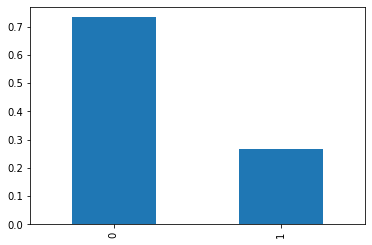

In [22]:
model = RandomForestClassifier(random_state=12345, 
                               n_estimators = 35, 
                               max_depth=7, 
                               class_weight='balanced')
model.fit(features_train, target_train)
predict = model.predict(features_valid)

print('F1:', f1_score(target_valid, predict))

accuracy_valid= accuracy_score(target_valid, predict)
print('Accuracy:',accuracy_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC:', auc_roc)

print()
predicted_valid = pd.Series(predict)
class_frequency = predicted_valid.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Чаще встречается целевой признак со значением 0

In [23]:
print(confusion_matrix(target_valid, predict))

[[1334  239]
 [ 131  296]]


- Модель чаще предсказывает отрицательные значения
- Почситаны значения AUC: 0.86, F1: 0.62, Accuracy: 0.81.


<div class="alert alert-block alert-success">
<b>Успех:</b> Дисбаланс исследован
  
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Здесь еще нужно посчитать AUC значение для ROC-кривой
  
</div>

<div class="alert alert-success"> 
<b>Успех[2]:</b> Tcnm

## Борьба с дисбалансом

In [55]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [56]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

In [57]:
#Обучим модель DecisionTreeClassifier
tree_model = DecisionTreeClassifier(random_state=12345, max_depth=7, class_weight='balanced')
tree_model.fit(features_upsampled, target_upsampled)
predict = tree_model.predict(features_valid)
print('F1:', f1_score(target_valid, predict))

accuracy_valid= accuracy_score(target_valid, predict)
print('Accuracy:',accuracy_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC:', auc_roc)

F1: 0.5730769230769232
Accuracy: 0.778
AUC: 0.8635455453637273


In [86]:
#Обучим модель RandomForestClassifier
model = RandomForestClassifier(random_state=12345, 
                               n_estimators = 37, 
                               max_depth=10, 
                               class_weight='balanced')
model.fit(features_upsampled, target_upsampled)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

predict = model.predict(features_valid)

print('F1:', f1_score(target_valid, predict))

accuracy_valid= accuracy_score(target_valid, predict)
print('Accuracy:',accuracy_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC:', auc_roc)

F1: 0.627492130115425
Accuracy: 0.8225
AUC: 0.8625964199734691



<div class="alert alert-block alert-success">
<b>Успех:</b> Радует достаточное количество методов для борьбы с дисбалансом 


<div class="alert alert-block alert-danger">
<b>Ошиьбка:</b> Попробуй пожалауйста и другие модели, также не забывай про ROC-AUC

<div class="alert alert-success"> 
<b>Успех[2]:</b> Есть

## Тестирование модели

In [87]:
test_prediction = model.predict(features_test)
print('F1:', f1_score(target_test, test_prediction))

F1: 0.5904977375565611


In [88]:
result = model.score(features_test, target_test) 
print("Accuracy:", result)

Accuracy: 0.819


AUC: 0.8625964199734691


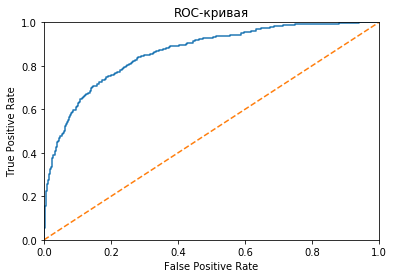

In [89]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC:',auc_roc)

plt.figure()

plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

# Вывод

 - Наиболее лучшая модель RandomForestClassifier
 - на обучающей выборке достигнуты целевые показатели F1: 0.62, Accuracy: 0.8, AUC: 0.86 при значениях гиперпараметров n_estimators = 37, max_depth=10
 - на тестовой выборке значения показателей составили F1: 0.59, Accuracy: 0.8, AUC: 0.86

<div class="alert alert-block alert-success">
<b>Успех:</b> С тестированием все в порядке! Тебе удалось достичь хороших показателей на тесте! 
</div>


<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Не забывай про итоговый вывод, это очень важная часть любого проекта, и заказчик уделит сюда особое внимание, также хорошо собрать все результаты в информативную таблицу
</div>


<div class="alert alert-danger"> 
<b>Ошибка[2]:</b> Попробуй достичь желаемое метрики, это можно сделать получше подбрав гиперпараметры. + Все еще не хватает здесь итогового вывода

**В самом начале допустил ошибку и никак не мог достигнуть целевых показателей**,

<div class="alert alert-danger"> 
    
<b>Ошибка[3]:</b> Молодец, что исправил и нашел ошибку самостоятельно, но целевой показатель должен быть достигунт на тестовой выборке. Рекомендуют обратить внимание на гиперпараметров `n_estimators`

**Подобрал параметры более оптимальные**

<div class="alert alert-block alert-success">
<b>Успех[2]:</b> Отлично
</div>


<div class="alert alert-block alert-info">
<b>Совет:</b>  <br>1) Можно также перед тестирование объединить выборки трейн+валид в одну обучающую выборку  <br> 2) Для понимания, а какие в итоге факторы важны при моделировании, можно выводить их важность, использую feature_importances_, ну и график заодно. Это будет смотреться очнь здорово: результативная метрика и график важности факторов)))<br> Очень ВАЖНАЯ для аналитики штука. Ведь нам не просто модель с метрикой нужна, а ещё и причины понять высокой/низкой метрики. Т.е. понять с какой силой сами факторы влияют на целевую.<br>
</div> 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*